91% completed

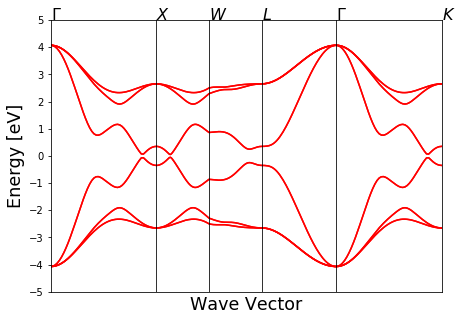

In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 22 14:01:44 2020

@author: timo
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 29 12:17:46 2020

@author: timo
"""
import numpy as np
import kwant
import matplotlib.pyplot as plt
import scipy.linalg as la

class sysParams:
    nOrbs =  6
    
    def __init__(self,t11 = -0.5, t22 = 0.5, t12 = 0.9, t21 = 0.9, lam = 0.0, ma = 1.65, model = 4):
        self.t = np.array([[t11, t12], [t21, t22]])
        self.lam = lam
        self.m = np.array([-ma, ma]) 
        self.spinOrb = [[0, -1j*lam, 0, 0, 0, lam],
                       [1j*lam, 0, 0, 0, 0, -1j*lam],
                       [0, 0, 0, -lam, 1j*lam, 0],
                       [0, 0, -lam, 0, 1j*lam, 0],
                       [0, 0, -1j*lam, -1j*lam, 0, 0],
                       [lam, 1j*lam, 0, 0, 0, 0]]
        
        self.model = model
        self.syst = self.makeSys()
        self.fsyst = self.makeSys().finalized()
        
class SnTe3D(sysParams):
    def makeSys(self):        
        def onsite(site):
            a = np.sum(site.tag) % 2
            os = self.m[a]* np.eye(6)
            return os + self.spinOrb
                      
        def hopping(site1,site2):
            a = np.sum(site1.tag) % 2
            b = np.sum(site2.tag) % 2
            
            d = np.array(site1.pos - site2.pos)
            d = d / np.sqrt(d @ d)
            dtd = np.outer(d, d)
            dtd = np.kron(np.eye(2),dtd)
       
            return self.t[a, b] * dtd
            
##############################################################################################################
        if self.model == 2:
            '''Lattice of the FCC unit cell'''
            lat = kwant.lattice.general([[1,0,0],[0,1,0],[0,0,1]],norbs = self.nOrbs)
            translations = kwant.lattice.TranslationalSymmetry([1,0,1],[1,1,0],[0,1,1])
            syst = kwant.Builder(symmetry=translations)
            syst[lat(0,0,0)] = onsite
            syst[lat(0,1,0)] = onsite
            
            self.symWalk = 2 # Choice for k-path
            self.nEvals = 12 # Number of bands
            
        if self.model == 4:
            '''Lattice of the tetragonal unit cell'''
            lat = kwant.lattice.general([[1,0,0],[0,1,0],[0,0,1]],norbs = self.nOrbs) # Equivalent to set of Pim
            translations = kwant.lattice.TranslationalSymmetry([0,2,0],[-1,0,1],[1,0,1]) # Equivalent to set of Pim
            syst = kwant.Builder(symmetry=translations)
            syst[lat(0, 0, 0)] = onsite
            syst[lat(1, 0, 0)] = onsite
            syst[lat(0, 1, 0)] = onsite
            syst[lat(1, 1, 0)] = onsite
                    
            self.symWalk = 4 # Choice for k-path
            self.nEvals = 24 # Number of bands
            
############################################################################################
        
        syst[lat.neighbors(1)] = hopping
        syst[lat.neighbors(2)] = hopping 
        syst = kwant.wraparound.wraparound(syst)
        return syst
    def calc(self,sym1 = [0.5,0.5,0.5],sym2 = [0,0,0], nKvals = 50): # nKvals = nhsp

############################################################################### 
        if self.model == 2:
            reciprocalVectors = [[np.pi,-np.pi,np.pi],[np.pi,np.pi,-np.pi],[-np.pi,np.pi,np.pi]]
            totalSym1 = np.dot(reciprocalVectors[0],sym1[0])+np.dot(reciprocalVectors[1],sym1[1])+np.dot(reciprocalVectors[2],sym1[2])
            totalSym2 = np.dot(reciprocalVectors[0],sym2[0])+np.dot(reciprocalVectors[1],sym2[1])+np.dot(reciprocalVectors[2],sym2[2])
            
            self.kx = np.linspace(totalSym1[0],totalSym2[0],nKvals)
            self.ky = np.linspace(totalSym1[1],totalSym2[1],nKvals)
            self.kz = np.linspace(totalSym1[2],totalSym2[2],nKvals)
            
        if self.model == 4:
            reciprocalVectors = [[np.pi,np.pi,0],[np.pi,-np.pi,0],[0,0,np.pi]]      
            totalSym1 = np.dot(reciprocalVectors[0],sym1[0])+np.dot(reciprocalVectors[1],sym1[1])+np.dot(reciprocalVectors[2],sym1[2])
            totalSym2 = np.dot(reciprocalVectors[0],sym2[0])+np.dot(reciprocalVectors[1],sym2[1])+np.dot(reciprocalVectors[2],sym2[2])
            
            self.kx = np.linspace(totalSym1[0],totalSym2[0],nKvals)
            self.ky = np.linspace(totalSym1[1],totalSym2[1],nKvals)
            self.kz = np.linspace(totalSym1[2],totalSym2[2],nKvals)

        self.nKvals = nKvals
        self.energy = np.zeros((nKvals,self.nEvals))
        
        def calcElement(x,y,z):
            mat=self.fsyst.hamiltonian_submatrix(sparse=False,params={'k_x':x,'k_y':y,'k_z':z})
            energy = la.eigvalsh(mat)
            return energy
        
        for i in range(nKvals):
            self.energy[i,:] = calcElement(self.kx[i],self.ky[i],self.kz[i])

    def geoPlot(self):
        
        def colors(site):
            c=['blue','yellow']
            a = np.sum(site.tag) % 2
            c=c[a]
            return c

        def hopColors(site1 ,site2):
            a = np.sum(site1.tag)%2
            b = np.sum(site2.tag)%2
            if a==b:  
                return 'green'
            else:  
                return 'red'
            
        def hopLineweight(site1,site2):
            d = np.array(site1.tag - site2.tag)
            if np.sqrt(d[0]**2 + d[1]**2 + d[2]**2) <= np.sqrt(2): 
                return 0.05
            else:
                return 0.05
        kwant.plot(self.syst, hop_lw=hopLineweight, site_size = 0.2, site_color=colors, hop_color = hopColors)

    def dispersionPlot(self):
        if self.symWalk == 2:
            symPoints = np.array([[0,0,0],[1,0,0],[1,0.5,0],[0.5,0.5,0],[0,0,0],[1,0,0]])
            symName = [r'$\Gamma$',r'$X$',r'$W$',r'$L$',r'$\Gamma$',r'$K$']
         
        
        
        if self.symWalk == 4:
            symPoints = np.array([[0,0,0],[0,0,1],[0.5,-0.5,1],[0,0,0],[0.5,0.5,0],[1,0,0],[1,0,1],[0.5,0.5,0]])
            symName = [r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$',r'$Z$',r'$R$',r'$A$',r'$Z$']    
        
        '''Need to change to range of j to the maximum energy levels equal to nEvals'''
        valEnergy = []
        conEnergy = []
        nhsp = 50 # See line 88
        if self.model == 2:
            hsp = 5
        if self.model == 4:
            hsp = 7
        self.a =  np.zeros(nhsp*hsp) # tetragonal: 140, FCC: 100
        for j in range(self.nEvals):
            xValSpace = [0]
            yValSpace = []
            xConSpace = [0]
            yConSpace = []
            self.xRange = [0]

            for i in range(symPoints.shape[0]-1):
                d = symPoints[i+1] - symPoints[i]
                self.calc(sym1=symPoints[i],sym2=symPoints[i+1])

                self.xRange = np.append(self.xRange,np.linspace(self.xRange[-1],self.xRange[-1]+np.sqrt(d@d),self.nKvals))

                xValSpace = np.append(xValSpace, np.linspace(xValSpace[-1],xValSpace[-1]+np.sqrt(d@d),self.nKvals))
                yValSpace = np.append(yValSpace, self.energy[:,j])
                valEnergy = np.append(valEnergy,yValSpace)
   
            self.a = np.vstack((self.a,yValSpace))
            xValSpace= xValSpace[1:]
            xConSpace= xConSpace[1:]

            "Comment alles hierbeneden als je phase diagram aan het maken bent anders heb je veel plots"
            plt.plot(xValSpace,yValSpace,'r')
            plt.plot(xConSpace,yConSpace,'r')

            print('\r' + str(int(j/self.nEvals*100))+'% completed',end='')
        a=0.8
        ax = plt.gca()
        ax.set_ylim([-5,5])
        ax.set_xlim([0,self.xRange[-1]])

        ax.annotate(symName[0],xy=(0,5),fontsize=a*20)
        ax.annotate(symName[-1],xy=(self.xRange[-1],5),fontsize=a*20)
        totalD = 0
        for i in range(len(symName)-2):
            
            d = symPoints[i+1] - symPoints[i]
            d = np.sqrt(d@d)
            totalD += d
            
            plt.axvline(x=totalD,c='k',linewidth=0.8)
            ax.annotate(symName[i+1],xy=(totalD,5),fontsize=a*20)

        plt.tick_params(labelbottom= False)
        ax.set_xticks([])
        plt.ylabel('Energy [eV]',fontsize=a*22)
        plt.yticks(np.arange(-5, 5.5, 1))
        plt.xlabel('Wave Vector',fontsize=a*22)
        plt.show()

def main():
    fig = plt.figure(figsize = (7,5))
    ses3D = SnTe3D(model = 2) # 2 = FCC, 4 = tetragonal
    #ses3D.geoPlot()
    ses3D.dispersionPlot()
main()  